<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/simpleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Barebones GAN in PyTorch for generating coin flips
By
Fayyaz Minhas

Let's consider a very simple coing toss as a process that generates coin flips with a probability of 0.3 of producing heads. We can describe the underlying probability distribution for this generative process (coin toss) as $p(x)$ where $x\in \{H=1,T=0\}$ is sampled from $p(x)$, i.e., $x\backsim p(x)$. We would like to use a Generative Adversarial Network (GAN) to model this process using a number of data samples or observations from the original process for training. Specifically, we would like to have a GAN with such a generator that you (and its discriminator) wouldn't be able to tell if a series of coin tosses has been generated using the GAN or the underlying true process! In more mathematical terms, we would like to train a generative model $x=G(z;\theta_G)$ that can generate samples $x$ using Normally distributed random input ($z\backsim N(0,1)$) such that the probability distribution of these generated samples $p_G(x)$ is close to $p(x)$ without knowing $p(x)$ in advance or explicitly modelling $p_G(x)$.

Using a GAN is an overkill for this simple task and there are much simpler and more effective ways of modelling this simple problem. However, this GAN based solution is intended to help you understand how GANs can model complex densities implicitly and can be used to generate samples that mimic the true or natural generative process.

We first simulate the coin toss and generate 1024 training samples below. The histogram shows the (sample estimate of) the true density.

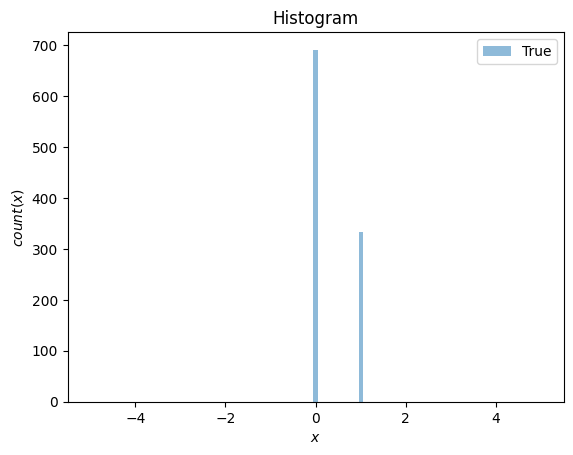

Example Data tensor([[1., 1., 1.,  ..., 0., 0., 1.]])


In [1]:
"""
A toy GAN to generate coin tosses
"""

# Let's model the natural density and generate some data using that

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
train_data_length = 1024
def cointoss(t):
  phead = 0.3
  return 1.0*(t<phead)

train_data = torch.zeros((train_data_length, 1))
train_data[:, 0] = cointoss(torch.rand(train_data_length))
bins = np.linspace(-5, 5, 100)
plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.show()
print('Example Data',train_data.T)

Below, we make a generator and a discriminator and train them with a batch size of 32. The generator will produce coin toss results which should have the same probabilities as the original coin and it will learn its weight parameters based on the observations only and its interaction with the discriminator. The generator takes a Gaussian random noise prior as input, i.e., its input is a single Gaussian Random number with mean zero and variance 1.0. It will learn to map this input number to the target variable (heads or tails) by learning the sampling based on given observations. Consequently, our generator is a single input, single output neural network.

The discriminator will take a coin toss as input and decide whether it corresponds to fake (generated by the Generator) or real (generated by the real process) coin flip by learning to produce an output of 0.0 for fake and a label of 1.0 for real samples.

We use binary cross entropy as the loss function in this case. At each training step the discriminator learns to classify real and fake data samples whereas the generator tries to produce samples that match the natural process and can fool the discriminator. For visualization, we plot the current estimate of the histogram after eevry few epochs and compare it to the true density. However, it is important to note that GANs do not explicitly model the density $p(x)$ but rather generate samples $x$ through an implicit modeling of the underlying probability density.

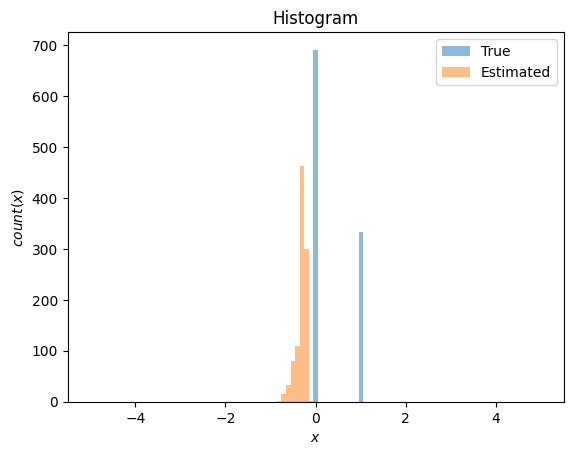

Epoch: 0 Loss D.: 0.6800934076309204
Epoch: 0 Loss G.: 0.6398191452026367


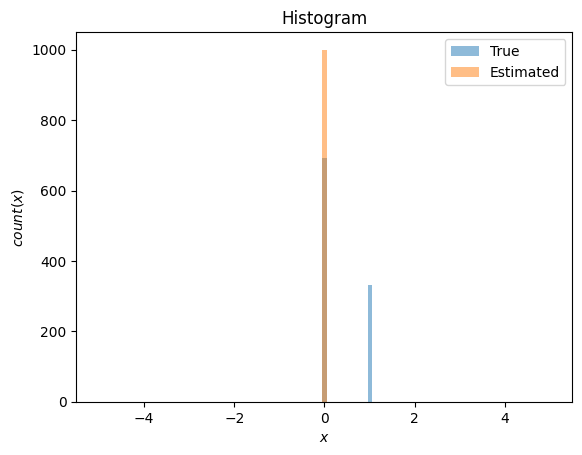

Epoch: 50 Loss D.: 0.6526055932044983
Epoch: 50 Loss G.: 0.7442654967308044


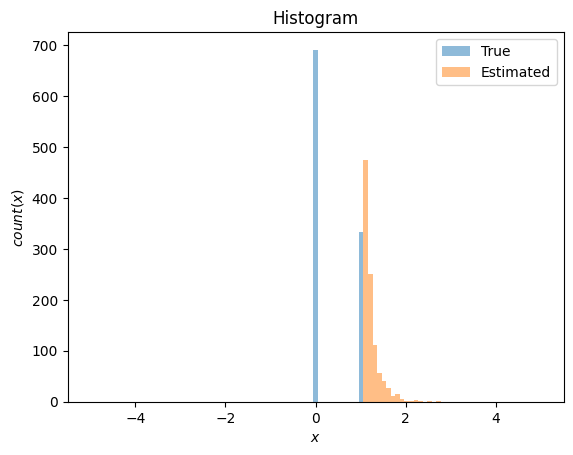

Epoch: 100 Loss D.: 0.6868093013763428
Epoch: 100 Loss G.: 0.8273391127586365


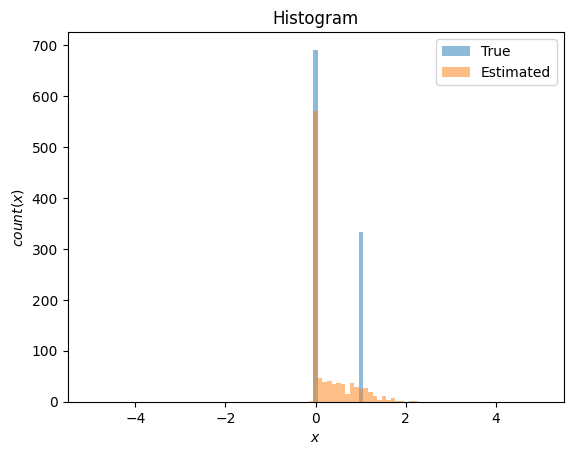

Epoch: 150 Loss D.: 0.6503440141677856
Epoch: 150 Loss G.: 0.7481417059898376


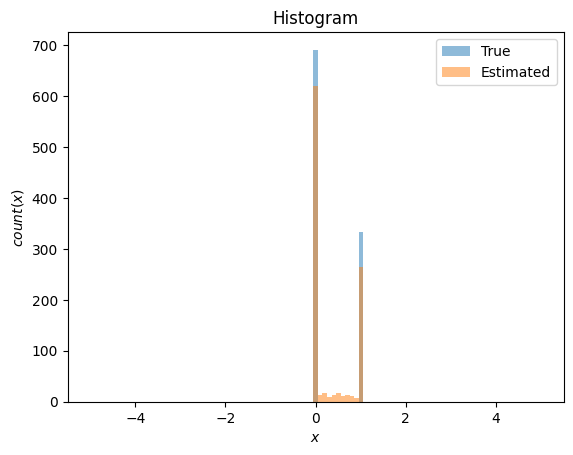

Epoch: 200 Loss D.: 0.6748540997505188
Epoch: 200 Loss G.: 0.7231884598731995


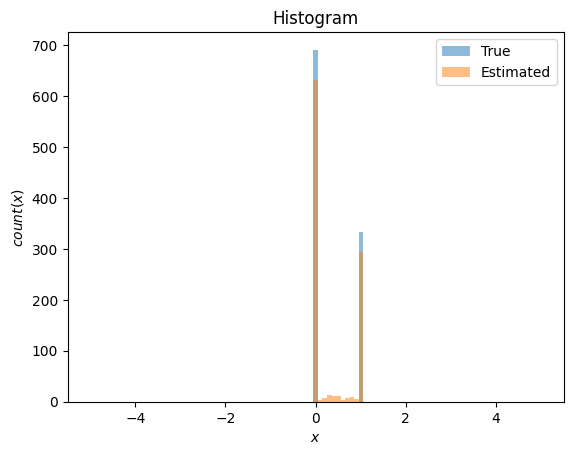

Epoch: 250 Loss D.: 0.6927518844604492
Epoch: 250 Loss G.: 0.6863502264022827


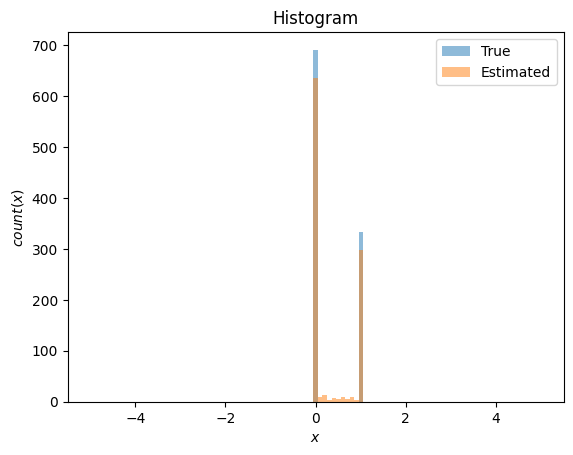

Epoch: 300 Loss D.: 0.6768521070480347
Epoch: 300 Loss G.: 0.7484076619148254


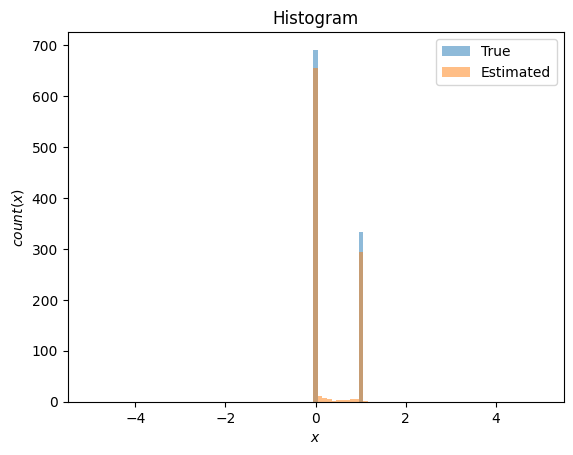

Epoch: 350 Loss D.: 0.683538019657135
Epoch: 350 Loss G.: 0.6938779354095459


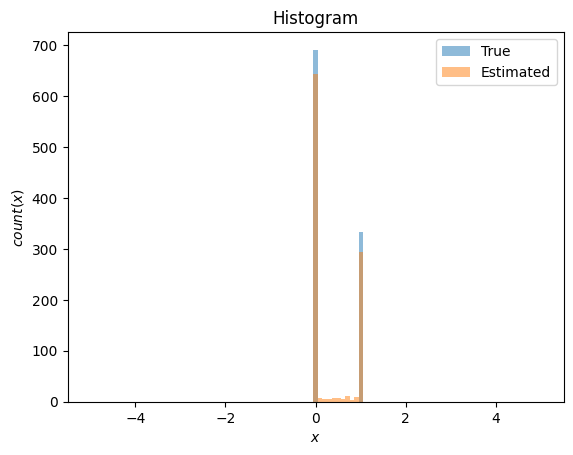

Epoch: 400 Loss D.: 0.6625877022743225
Epoch: 400 Loss G.: 0.7505003809928894


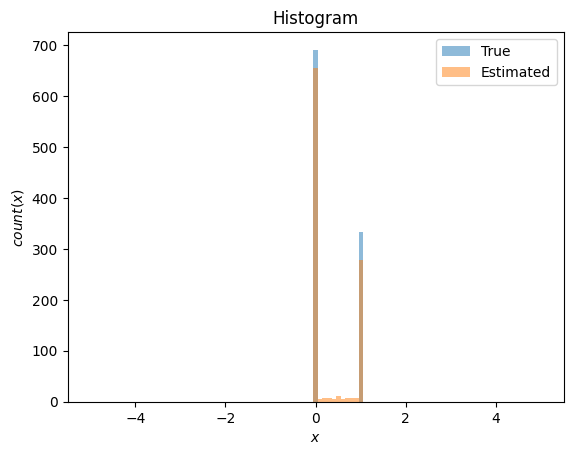

Epoch: 450 Loss D.: 0.6710613965988159
Epoch: 450 Loss G.: 0.8186719417572021


In [4]:
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

# Discriminator classifies a given input into real (1) or fake (0)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()


#Generator generates a sample using latent random noise factors as input
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
showPlot=True
for epoch in range(num_epochs):

    if epoch%50==0 and showPlot:
        latent_space_samples = torch.randn(1000, 1)
        generated_samples = generator(latent_space_samples)
        latent_space_samples = torch.randn(1000, 1).detach()
        generated_samples = generated_samples.detach()
        plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
        plt.hist(generated_samples[:,0],bins=bins,alpha=0.5, label='Estimated')
        plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
        plt.show()


    for n, (real_samples, _) in enumerate(train_loader):
        # Data for descriminator training
        real_samples_labels = torch.ones((batch_size, 1)) # labels for real samples indicated by 1
        latent_space_samples = torch.randn((batch_size, 1)) # random noise input to the generator
        generated_samples = generator(latent_space_samples) # generated samples
        generated_samples_labels = torch.zeros((batch_size, 1)) # labels for generated samples indicated by 0
        all_samples = torch.cat((real_samples, generated_samples)) # real and generated samples
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)) # labels for real and generated samples

        # Discriminator training so that it is able to detect the difference between real and generated samples
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for generator training
        latent_space_samples = torch.randn((batch_size, 1))

        # Generator training so that the generator generates samples which are indistinguishible from real ones
        # This is achieved by min_{\theta_G}  loss(discriminator(Generator(z;theta_G)),1.0) which is a measure of the generator's (in)ability to fool the discriminator into "thinking" that the generated samples are real
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, torch.ones_like(output_discriminator_generated))
        # this is the loss for the generator: essentially the error of the discriminator in classifying the samples generated by the generator as real
        # We want to update the weights of the generator such that its outputs produce as small a loss as possible which essentially means producing outputs that fool the discriminator
        # alternatively, you can also use:         loss_generator = -1*loss_function(output_discriminator_generated, torch.zeros_like(output_discriminator_generated))
        loss_generator.backward()
        optimizer_generator.step()


        # Output value of loss function
        if epoch % 50 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")





Once the GAN has converged, we can generate samples using the generator and plot their histogram and compare it to the true distribution. Notice that the generator is simply mapping a single input (Gaussian random input) into a Heads (1.0) or Tails (0.0) by implicitly modelling the underlying generative process using its interaction with the discriminator. Below, we can see this mapping for the trained GAN.

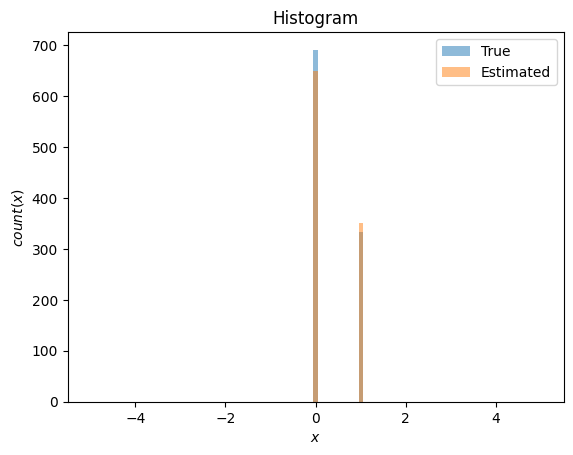

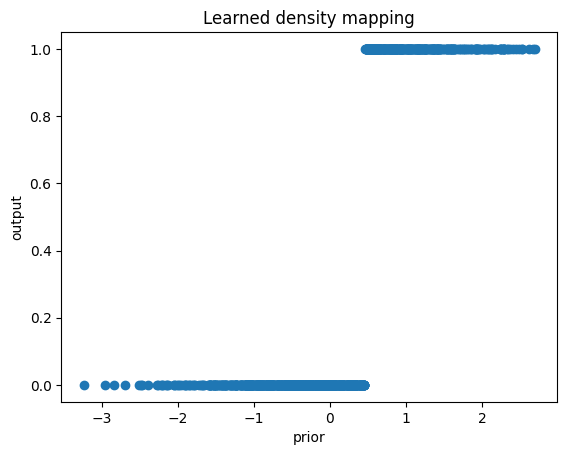

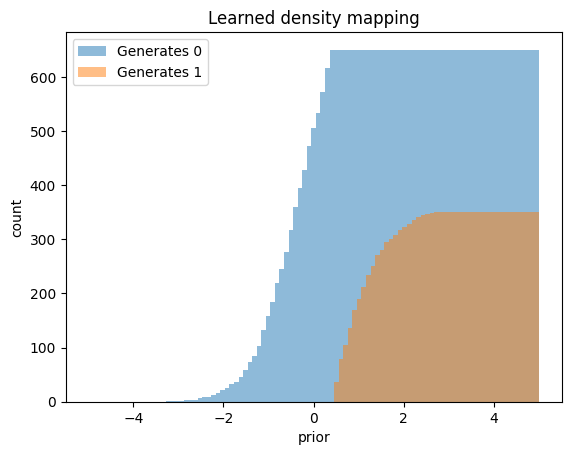

Generated Samples tensor([-0., -0., -0., 1., -0., 1., -0., -0., -0., -0., 1., -0., -0., 1., -0., 1., -0., -0.,
        -0., -0., -0., 1., 1., 1., -0., 1., -0., 0., 1., -0., 1., -0., -0., -0., 1., -0.,
        -0., -0., 1., -0., 1., -0., -0., 1., -0., 0., 1., 1., 1., -0.])


<ipython-input-5-3e29cbd2755c>:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  print('Generated Samples',torch.round(generated_samples[:50].T))


In [5]:
plt.figure()
latent_space_samples = torch.randn(1000, 1)
generated_samples = generator(latent_space_samples)
latent_space_samples = latent_space_samples.detach()[:,0]
generated_samples = np.round(generated_samples.detach()[:,0])
plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
plt.hist(generated_samples,bins=bins,alpha=0.5, label='Estimated')
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.figure()
plt.plot(latent_space_samples,generated_samples,'o')
plt.xlabel('prior');plt.ylabel('output');plt.title('Learned density mapping')
plt.figure()
plt.hist(latent_space_samples[generated_samples==0.0],cumulative=True,bins=bins,alpha=0.5, label='Generates 0')
plt.hist(latent_space_samples[generated_samples==1.0],cumulative=True,bins=bins,alpha=0.5, label='Generates 1')
#plt.hist(latent_space_samples,cumulative=True,bins=bins,alpha=0.5, label='Cumulative')
plt.title('Histogram');plt.xlabel('$z$');plt.ylabel('$count(z)$');plt.legend()

plt.xlabel('prior');plt.ylabel('count');plt.title('Learned density mapping')
plt.show()
print('Generated Samples',torch.round(generated_samples[:50].T))

## Exercise:

See if you can train a model with a diffenrent probability of heads.

See if you can train a GAN to model more complex 1-D density estimation problems.

See if you can change the loss function and architectures of the generator and discriminator networks to learn the desnsity more efficiently.



### Acknowledgements

Some parts of this tutorial have been inspired from the source below which is strongly recommended for reading.

Raevskiy, Mikhail. “Write Your First Generative Adversarial Network Model on PyTorch.” Medium, August 31, 2020. https://medium.com/dev-genius/write-your-first-generative-adversarial-network-model-on-pytorch-7dc0c7c892c7.
